# Zillow Home Price Data Processing

This notebook provides functions to query Zillow home price data by zip code and county/metro area.

In [48]:
! pip install pandas

In [49]:
import pandas as pd
from datetime import datetime
from typing import Optional, Dict, List

## Load Data

In [50]:
# Load the CSV files
zip_df = pd.read_csv('zillow_data/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
metro_df = pd.read_csv('zillow_data/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

print(f"Zip code data shape: {zip_df.shape}")
print(f"Metro/County data shape: {metro_df.shape}")

Zip code data shape: (26309, 319)
Metro/County data shape: (895, 315)


## Inspect Data Structure

In [51]:
# Display first few rows and columns
print("\n=== ZIP CODE DATA ===")
print(zip_df.iloc[:5, :15])  # First 5 rows, first 15 columns

print("\n=== METRO/COUNTY DATA ===")
print(metro_df.iloc[:5, :15])  # First 5 rows, first 15 columns


=== ZIP CODE DATA ===
   RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     91982         1       77494        zip        TX    TX      Katy   
1     61148         2        8701        zip        NJ    NJ  Lakewood   
2     91940         3       77449        zip        TX    TX      Katy   
3     62080         4       11368        zip        NY    NY  New York   
4     91733         5       77084        zip        TX    TX   Houston   

                                   Metro        CountyName     2000-01-31  \
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  207990.862896   
1  New York-Newark-Jersey City, NY-NJ-PA      Ocean County  115428.100095   
2   Houston-The Woodlands-Sugar Land, TX     Harris County  103617.439109   
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County  172177.874323   
4   Houston-The Woodlands-Sugar Land, TX     Harris County  103084.537334   

      2000-02-29     2000-03-31     2000-04-30     2000-05-31     200

In [52]:
# Check column names
print("\nZip data columns (first 20):", list(zip_df.columns[:20]))
print("\nMetro data columns (first 20):", list(metro_df.columns[:20]))


Zip data columns (first 20): ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31', '2000-11-30']

Metro data columns (first 20): ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31', '2000-11-30', '2000-12-31', '2001-01-31', '2001-02-28', '2001-03-31']


## Create Dictionaries of Available Locations

In [53]:
def get_available_zipcodes() -> Dict[str, Dict[str, str]]:
    """
    Returns a dictionary of available zip codes with their location information.
    
    Returns:
        Dict mapping zip code to location info (city, state, county)
    """
    zipcodes = {}
    
    for _, row in zip_df.iterrows():
        zipcode = str(row['RegionName'])
        zipcodes[zipcode] = {
            'city': row.get('City', 'N/A'),
            'state': row.get('State', 'N/A'),
            'county': row.get('CountyName', 'N/A'),
            'metro': row.get('Metro', 'N/A')
        }
    
    return zipcodes

def get_available_metros() -> Dict[str, Dict[str, str]]:
    """
    Returns a dictionary of available metro areas/counties with their information.
    
    Returns:
        Dict mapping metro name to location info (state, region type)
    """
    metros = {}
    
    for _, row in metro_df.iterrows():
        metro_name = row['RegionName']
        metros[metro_name] = {
            'state': row.get('StateName', 'N/A'),
            'region_type': row.get('RegionType', 'N/A'),
            'size_rank': row.get('SizeRank', 'N/A')
        }
    
    return metros

In [54]:
# Create the dictionaries
available_zipcodes = get_available_zipcodes()
available_metros = get_available_metros()

print(f"Total available zip codes: {len(available_zipcodes)}")
print(f"Total available metro areas: {len(available_metros)}")

# Show sample entries
print("\nSample zip codes:")
for i, (zipcode, info) in enumerate(list(available_zipcodes.items())[:5]):
    print(f"  {zipcode}: {info}")

print("\nSample metro areas:")
for i, (metro, info) in enumerate(list(available_metros.items())[:5]):
    print(f"  {metro}: {info}")

Total available zip codes: 26309
Total available metro areas: 895

Sample zip codes:
  77494: {'city': 'Katy', 'state': 'TX', 'county': 'Fort Bend County', 'metro': 'Houston-The Woodlands-Sugar Land, TX'}
  8701: {'city': 'Lakewood', 'state': 'NJ', 'county': 'Ocean County', 'metro': 'New York-Newark-Jersey City, NY-NJ-PA'}
  77449: {'city': 'Katy', 'state': 'TX', 'county': 'Harris County', 'metro': 'Houston-The Woodlands-Sugar Land, TX'}
  11368: {'city': 'New York', 'state': 'NY', 'county': 'Queens County', 'metro': 'New York-Newark-Jersey City, NY-NJ-PA'}
  77084: {'city': 'Houston', 'state': 'TX', 'county': 'Harris County', 'metro': 'Houston-The Woodlands-Sugar Land, TX'}

Sample metro areas:
  United States: {'state': nan, 'region_type': 'country', 'size_rank': 0}
  New York, NY: {'state': 'NY', 'region_type': 'msa', 'size_rank': 1}
  Los Angeles, CA: {'state': 'CA', 'region_type': 'msa', 'size_rank': 2}
  Chicago, IL: {'state': 'IL', 'region_type': 'msa', 'size_rank': 3}
  Dallas,

## Data Query Functions

In [55]:
def convert_to_month_format(date_input: str) -> str:
    """
    Convert various date formats to YYYY-MM-DD format (end of month).
    
    Args:
        date_input: Date string in formats like 'YYYY-MM', 'YYYY-MM-DD', 'MM/YYYY', etc.
    
    Returns:
        Date string in 'YYYY-MM-DD' format (last day of month)
    """
    try:
        # Try parsing common formats
        for fmt in ['%Y-%m-%d', '%Y-%m', '%m/%Y', '%Y/%m', '%m-%Y']:
            try:
                date_obj = datetime.strptime(date_input, fmt)
                # Get last day of month
                if date_obj.month == 12:
                    next_month = date_obj.replace(year=date_obj.year + 1, month=1, day=1)
                else:
                    next_month = date_obj.replace(month=date_obj.month + 1, day=1)
                last_day = (next_month - pd.Timedelta(days=1)).strftime('%Y-%m-%d')
                return last_day
            except ValueError:
                continue
        
        raise ValueError(f"Unable to parse date: {date_input}")
    except Exception as e:
        raise ValueError(f"Error converting date '{date_input}': {str(e)}")


def get_home_price_by_zipcode(zipcode: str, date: str) -> Optional[float]:
    """
    Get home price for a specific zip code and date.
    
    Args:
        zipcode: ZIP code as string (e.g., '10001')
        date: Date in various formats (e.g., '2024-01', '2024-01-31', '01/2024')
    
    Returns:
        Home price as float, or None if not found
    """
    try:
        # Convert date to proper format
        formatted_date = convert_to_month_format(date)
        
        # Find the row for this zipcode
        zip_row = zip_df[zip_df['RegionName'] == int(zipcode)]
        
        if zip_row.empty:
            print(f"Zip code {zipcode} not found in dataset")
            return None
        
        # Check if date column exists
        if formatted_date not in zip_df.columns:
            print(f"Date {formatted_date} not found in dataset")
            print(f"Available date range: {zip_df.columns[9]} to {zip_df.columns[-1]}")
            return None
        
        # Get the price
        price = zip_row[formatted_date].values[0]
        
        return float(price) if pd.notna(price) else None
        
    except Exception as e:
        print(f"Error retrieving price: {str(e)}")
        return None


def get_home_price_by_metro(metro_name: str, date: str) -> Optional[float]:
    """
    Get home price for a specific metro area/county and date.
    
    Args:
        metro_name: Metro area name (e.g., 'New York, NY' or 'Chicago, IL')
        date: Date in various formats (e.g., '2024-01', '2024-01-31', '01/2024')
    
    Returns:
        Home price as float, or None if not found
    """
    try:
        # Convert date to proper format
        formatted_date = convert_to_month_format(date)
        
        # Find the row for this metro area
        metro_row = metro_df[metro_df['RegionName'] == metro_name]
        
        if metro_row.empty:
            print(f"Metro area '{metro_name}' not found in dataset")
            return None
        
        # Check if date column exists
        if formatted_date not in metro_df.columns:
            print(f"Date {formatted_date} not found in dataset")
            print(f"Available date range: {metro_df.columns[5]} to {metro_df.columns[-1]}")
            return None
        
        # Get the price
        price = metro_row[formatted_date].values[0]
        
        return float(price) if pd.notna(price) else None
        
    except Exception as e:
        print(f"Error retrieving price: {str(e)}")
        return None

## Example Usage

In [56]:
# Example 1: Get price by zip code
zipcode = '10001'  # Manhattan, NY
date = '2024-01'

price = get_home_price_by_zipcode(zipcode, date)
if price:
    print(f"Home price in zip code {zipcode} for {date}: ${price:,.2f}")
    print(f"Location info: {available_zipcodes.get(zipcode, 'Not found')}")

Home price in zip code 10001 for 2024-01: $1,751,289.30
Location info: {'city': 'New York', 'state': 'NY', 'county': 'New York County', 'metro': 'New York-Newark-Jersey City, NY-NJ-PA'}


In [57]:
# Example 2: Get price by metro area
metro = 'New York, NY'
date = '2024-01'

price = get_home_price_by_metro(metro, date)
if price:
    print(f"Home price in {metro} for {date}: ${price:,.2f}")
    print(f"Metro info: {available_metros.get(metro, 'Not found')}")

Home price in New York, NY for 2024-01: $646,099.00
Metro info: {'state': 'NY', 'region_type': 'msa', 'size_rank': 1}


In [58]:
# Example 3: Search for zip codes in a specific city
city_to_search = 'New York'
print(f"\nZip codes in {city_to_search}:")
for zipcode, info in available_zipcodes.items():
    if info['city'] == city_to_search:
        print(f"  {zipcode}: {info['county']}, {info['state']}")
        # Limit output
        if list(available_zipcodes.keys()).index(zipcode) > 10:
            print("  ... (showing first 10)")
            break


Zip codes in New York:
  11368: Queens County, NY
  11385: Queens County, NY
  11208: Kings County, NY
  11236: Kings County, NY
  ... (showing first 10)


In [59]:
# Example 4: Search for metros in a specific state
state_to_search = 'NY'
print(f"\nMetro areas in {state_to_search}:")
count = 0
for metro, info in available_metros.items():
    if info['state'] == state_to_search:
        print(f"  {metro} ({info['region_type']})")
        count += 1
        if count >= 10:
            print("  ... (showing first 10)")
            break


Metro areas in NY:
  New York, NY (msa)
  Buffalo, NY (msa)
  Rochester, NY (msa)
  Albany, NY (msa)
  Syracuse, NY (msa)
  Utica, NY (msa)
  Binghamton, NY (msa)
  Kingston, NY (msa)
  Jamestown, NY (msa)
  Glens Falls, NY (msa)
  ... (showing first 10)


## Helper Function: Get Price History

In [60]:
def get_price_history_zipcode(zipcode: str, start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """
    Get price history for a zip code over a date range.
    
    Args:
        zipcode: ZIP code as string
        start_date: Start date (optional, defaults to earliest available)
        end_date: End date (optional, defaults to latest available)
    
    Returns:
        DataFrame with dates and prices
    """
    zip_row = zip_df[zip_df['RegionName'] == int(zipcode)]
    
    if zip_row.empty:
        print(f"Zip code {zipcode} not found")
        return pd.DataFrame()
    
    # Get date columns (skip metadata columns)
    date_cols = [col for col in zip_df.columns if col not in 
                 ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 
                  'State', 'City', 'Metro', 'CountyName']]
    
    # Extract prices
    prices = zip_row[date_cols].T
    prices.columns = ['Price']
    prices.index.name = 'Date'
    prices = prices.reset_index()
    prices['Date'] = pd.to_datetime(prices['Date'])
    
    # Filter by date range if provided
    if start_date:
        start = pd.to_datetime(convert_to_month_format(start_date))
        prices = prices[prices['Date'] >= start]
    if end_date:
        end = pd.to_datetime(convert_to_month_format(end_date))
        prices = prices[prices['Date'] <= end]
    
    return prices.dropna()


def get_price_history_metro(metro_name: str, start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """
    Get price history for a metro area over a date range.
    
    Args:
        metro_name: Metro area name
        start_date: Start date (optional, defaults to earliest available)
        end_date: End date (optional, defaults to latest available)
    
    Returns:
        DataFrame with dates and prices
    """
    metro_row = metro_df[metro_df['RegionName'] == metro_name]
    
    if metro_row.empty:
        print(f"Metro area '{metro_name}' not found")
        return pd.DataFrame()
    
    # Get date columns (skip metadata columns)
    date_cols = [col for col in metro_df.columns if col not in 
                 ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']]
    
    # Extract prices
    prices = metro_row[date_cols].T
    prices.columns = ['Price']
    prices.index.name = 'Date'
    prices = prices.reset_index()
    prices['Date'] = pd.to_datetime(prices['Date'])
    
    # Filter by date range if provided
    if start_date:
        start = pd.to_datetime(convert_to_month_format(start_date))
        prices = prices[prices['Date'] >= start]
    if end_date:
        end = pd.to_datetime(convert_to_month_format(end_date))
        prices = prices[prices['Date'] <= end]
    
    return prices.dropna()

In [61]:
# Example: Get price history for a zip code
history = get_price_history_zipcode('10001', start_date='2020-01', end_date='2024-12')
print(f"\nPrice history for zip code 10001 (2020-2024):")
print(history.head(10))
print(f"\nTotal months: {len(history)}")


Price history for zip code 10001 (2020-2024):
          Date         Price
240 2020-01-31  2.507684e+06
241 2020-02-29  2.413087e+06
242 2020-03-31  2.325311e+06
243 2020-04-30  2.254255e+06
244 2020-05-31  2.218095e+06
245 2020-06-30  2.189595e+06
246 2020-07-31  2.169900e+06
247 2020-08-31  2.151729e+06
248 2020-09-30  2.155926e+06
249 2020-10-31  2.160461e+06

Total months: 60


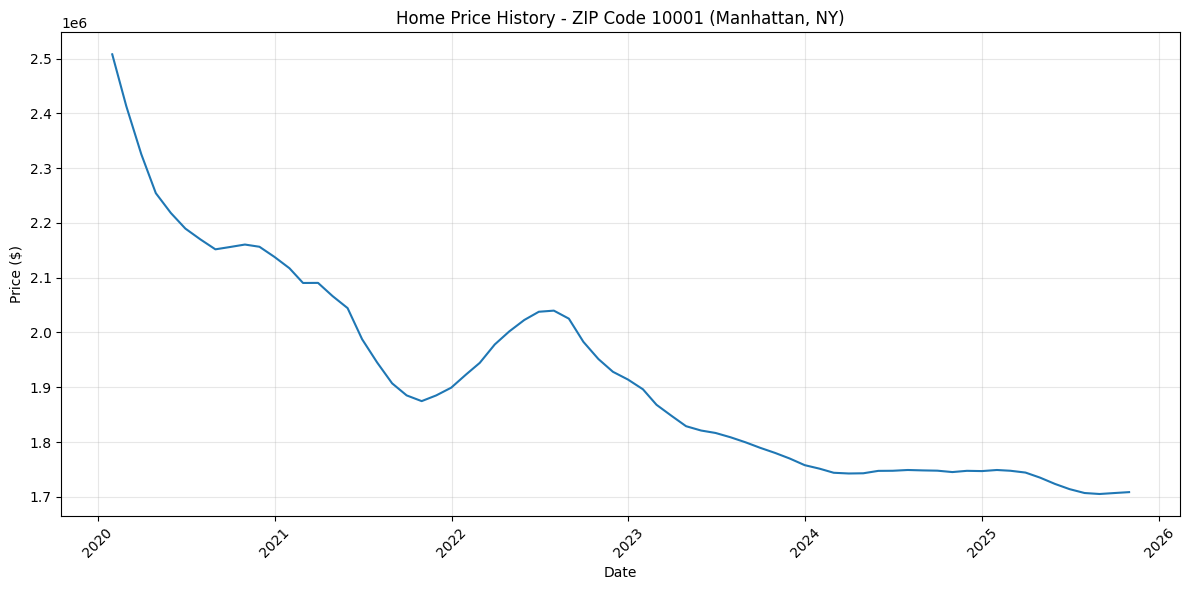

In [62]:
# Example: Plot price history
import matplotlib.pyplot as plt

history = get_price_history_zipcode('10001', start_date='2020-01')
if not history.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(history['Date'], history['Price'])
    plt.title('Home Price History - ZIP Code 10001 (Manhattan, NY)')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## yfinance API Functions

This section provides functions to query stock tickers, cryptocurrency, and forex prices using the yfinance API.


In [63]:
! pip install yfinance


In [64]:
import yfinance as yf
from datetime import datetime, date


### Price Query Functions


In [65]:
def parse_date(date_input):
    """
    Parse date input in various formats and return datetime object.
    
    Args:
        date_input: Date as string (e.g., '2024-01-15', '2024-01', '01/15/2024') or datetime/date object
    
    Returns:
        datetime object
    """
    if isinstance(date_input, (datetime, date)):
        return date_input if isinstance(date_input, datetime) else datetime.combine(date_input, datetime.min.time())
    
    # Try various string formats
    formats = ['%Y-%m-%d', '%Y-%m', '%m/%d/%Y', '%d/%m/%Y', '%Y/%m/%d']
    for fmt in formats:
        try:
            return datetime.strptime(date_input, fmt)
        except ValueError:
            continue
    
    raise ValueError(f"Unable to parse date: {date_input}")


def get_ticker_price(ticker: str, date_input: str) -> Optional[float]:
    """
    Get stock ticker price for a specific date.
    
    Args:
        ticker: Stock ticker symbol (e.g., 'AAPL', 'GOOGL', 'MSFT')
        date_input: Date in various formats (e.g., '2024-01-15', '2024-01', '01/15/2024')
    
    Returns:
        Closing price as float, or None if not found
    
    Examples:
        >>> get_ticker_price('AAPL', '2024-01-15')
        >>> get_ticker_price('GOOGL', '2024-01-01')
    """
    try:
        date_obj = parse_date(date_input)
        
        # Download historical data for the date (need a range for yfinance)
        start_date = date_obj.strftime('%Y-%m-%d')
        end_date = (date_obj + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        
        ticker_obj = yf.Ticker(ticker)
        hist = ticker_obj.history(start=start_date, end=end_date)
        
        if hist.empty:
            print(f"No data found for ticker {ticker} on {start_date}")
            return None
        
        # Get the closest date (usually the exact date)
        price = hist['Close'].iloc[0]
        return float(price)
        
    except Exception as e:
        print(f"Error retrieving ticker price for {ticker} on {date_input}: {str(e)}")
        return None


def get_crypto_price(symbol: str, date_input: str) -> Optional[float]:
    """
    Get cryptocurrency price for a specific date.
    
    Args:
        symbol: Crypto symbol (e.g., 'BTC-USD', 'ETH-USD', 'BNB-USD')
        date_input: Date in various formats (e.g., '2024-01-15', '2024-01', '01/15/2024')
    
    Returns:
        Closing price as float, or None if not found
    
    Examples:
        >>> get_crypto_price('BTC-USD', '2024-01-15')
        >>> get_crypto_price('ETH-USD', '2024-01-01')
    """
    try:
        date_obj = parse_date(date_input)
        
        # Download historical data for the date
        start_date = date_obj.strftime('%Y-%m-%d')
        end_date = (date_obj + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        
        ticker_obj = yf.Ticker(symbol)
        hist = ticker_obj.history(start=start_date, end=end_date)
        
        if hist.empty:
            print(f"No data found for crypto {symbol} on {start_date}")
            return None
        
        # Get the closing price
        price = hist['Close'].iloc[0]
        return float(price)
        
    except Exception as e:
        print(f"Error retrieving crypto price for {symbol} on {date_input}: {str(e)}")
        return None


def get_fx_price(pair: str, date_input: str) -> Optional[float]:
    """
    Get foreign exchange (forex) rate for a specific date.
    
    Args:
        pair: FX pair symbol in yfinance format (e.g., 'EURUSD=X', 'GBPUSD=X', 'JPYUSD=X')
              Format: BASEQUOTE=X (e.g., EURUSD=X means EUR/USD rate)
        date_input: Date in various formats (e.g., '2024-01-15', '2024-01', '01/15/2024')
    
    Returns:
        Exchange rate as float, or None if not found
    
    Examples:
        >>> get_fx_price('EURUSD=X', '2024-01-15')  # EUR/USD rate
        >>> get_fx_price('GBPUSD=X', '2024-01-01')  # GBP/USD rate
        >>> get_fx_price('JPYUSD=X', '2024-01-15')  # JPY/USD rate
    """
    try:
        date_obj = parse_date(date_input)
        
        # Download historical data for the date
        start_date = date_obj.strftime('%Y-%m-%d')
        end_date = (date_obj + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        
        ticker_obj = yf.Ticker(pair)
        hist = ticker_obj.history(start=start_date, end=end_date)
        
        if hist.empty:
            print(f"No data found for FX pair {pair} on {start_date}")
            return None
        
        # Get the closing rate
        rate = hist['Close'].iloc[0]
        return float(rate)
        
    except Exception as e:
        print(f"Error retrieving FX price for {pair} on {date_input}: {str(e)}")
        return None


### Example Usage: yfinance Functions


In [66]:
# Example 1: Get stock ticker price
ticker = 'AAPL'
price_date = '2024-01-15'

price = get_ticker_price(ticker, price_date)
if price:
    print(f"{ticker} price on {price_date}: ${price:.2f}")


$AAPL: possibly delisted; no price data found  (1d 2024-01-15 -> 2024-01-16)


No data found for ticker AAPL on 2024-01-15


In [67]:
# Example 2: Get cryptocurrency price
crypto = 'BTC-USD'
price_date = '2024-01-15'

price = get_crypto_price(crypto, price_date)
if price:
    print(f"{crypto} price on {price_date}: ${price:,.2f}")


BTC-USD price on 2024-01-15: $42,511.97


In [68]:
# Example 3: Get forex rate
fx_pair = 'EURUSD=X'  # EUR/USD exchange rate
price_date = '2024-01-15'

rate = get_fx_price(fx_pair, price_date)
if rate:
    print(f"{fx_pair} rate on {price_date}: {rate:.4f}")
    print(f"This means 1 EUR = ${rate:.4f} USD")


EURUSD=X rate on 2024-01-15: 1.0946
This means 1 EUR = $1.0946 USD


In [69]:
# Example 4: Get multiple prices for the same date
target_date = '2024-01-15'

print(f"\nPrices on {target_date}:")
print("-" * 50)

# Stock
aapl_price = get_ticker_price('AAPL', target_date)
if aapl_price:
    print(f"AAPL (Apple): ${aapl_price:.2f}")

# Crypto
btc_price = get_crypto_price('BTC-USD', target_date)
if btc_price:
    print(f"BTC-USD (Bitcoin): ${btc_price:,.2f}")

# Forex
eurusd = get_fx_price('EURUSD=X', target_date)
if eurusd:
    print(f"EURUSD=X: {eurusd:.4f}")

gbpusd = get_fx_price('GBPUSD=X', target_date)
if gbpusd:
    print(f"GBPUSD=X: {gbpusd:.4f}")


$AAPL: possibly delisted; no price data found  (1d 2024-01-15 -> 2024-01-16)



Prices on 2024-01-15:
--------------------------------------------------
No data found for ticker AAPL on 2024-01-15
BTC-USD (Bitcoin): $42,511.97
EURUSD=X: 1.0946
GBPUSD=X: 1.2737


### Helper: Get Price History (yfinance)

Functions to get historical price data over a date range.


In [70]:
def get_ticker_history(ticker: str, start_date: str = None, end_date: str = None, period: str = '1y') -> pd.DataFrame:
    """
    Get historical price data for a stock ticker.
    
    Args:
        ticker: Stock ticker symbol (e.g., 'AAPL', 'GOOGL')
        start_date: Start date (optional, format: 'YYYY-MM-DD')
        end_date: End date (optional, format: 'YYYY-MM-DD')
        period: Period if start/end not specified (default: '1y', options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
    
    Returns:
        DataFrame with historical prices
    """
    try:
        ticker_obj = yf.Ticker(ticker)
        
        if start_date and end_date:
            hist = ticker_obj.history(start=start_date, end=end_date)
        else:
            hist = ticker_obj.history(period=period)
        
        if hist.empty:
            print(f"No historical data found for ticker {ticker}")
            return pd.DataFrame()
        
        return hist
        
    except Exception as e:
        print(f"Error retrieving history for {ticker}: {str(e)}")
        return pd.DataFrame()


def get_crypto_history(symbol: str, start_date: str = None, end_date: str = None, period: str = '1y') -> pd.DataFrame:
    """
    Get historical price data for a cryptocurrency.
    
    Args:
        symbol: Crypto symbol (e.g., 'BTC-USD', 'ETH-USD')
        start_date: Start date (optional, format: 'YYYY-MM-DD')
        end_date: End date (optional, format: 'YYYY-MM-DD')
        period: Period if start/end not specified (default: '1y')
    
    Returns:
        DataFrame with historical prices
    """
    try:
        ticker_obj = yf.Ticker(symbol)
        
        if start_date and end_date:
            hist = ticker_obj.history(start=start_date, end=end_date)
        else:
            hist = ticker_obj.history(period=period)
        
        if hist.empty:
            print(f"No historical data found for crypto {symbol}")
            return pd.DataFrame()
        
        return hist
        
    except Exception as e:
        print(f"Error retrieving history for {symbol}: {str(e)}")
        return pd.DataFrame()


def get_fx_history(pair: str, start_date: str = None, end_date: str = None, period: str = '1y') -> pd.DataFrame:
    """
    Get historical exchange rate data for a forex pair.
    
    Args:
        pair: FX pair symbol (e.g., 'EURUSD=X', 'GBPUSD=X')
        start_date: Start date (optional, format: 'YYYY-MM-DD')
        end_date: End date (optional, format: 'YYYY-MM-DD')
        period: Period if start/end not specified (default: '1y')
    
    Returns:
        DataFrame with historical rates
    """
    try:
        ticker_obj = yf.Ticker(pair)
        
        if start_date and end_date:
            hist = ticker_obj.history(start=start_date, end=end_date)
        else:
            hist = ticker_obj.history(period=period)
        
        if hist.empty:
            print(f"No historical data found for FX pair {pair}")
            return pd.DataFrame()
        
        return hist
        
    except Exception as e:
        print(f"Error retrieving history for {pair}: {str(e)}")
        return pd.DataFrame()


In [71]:
# Example: Get historical data for multiple assets
start = '2023-01-01'
end = '2024-01-31'

print("Historical Data Examples:")
print("=" * 60)

# Stock history
aapl_hist = get_ticker_history('AAPL', start_date=start, end_date=end)
if not aapl_hist.empty:
    print(f"\nAAPL (Last 5 rows):")
    print(aapl_hist[['Close']].tail())

# Crypto history
btc_hist = get_crypto_history('BTC-USD', start_date=start, end_date=end)
if not btc_hist.empty:
    print(f"\nBTC-USD (Last 5 rows):")
    print(btc_hist[['Close']].tail())

# Forex history
eurusd_hist = get_fx_history('EURUSD=X', start_date=start, end_date=end)
if not eurusd_hist.empty:
    print(f"\nEURUSD=X (Last 5 rows):")
    print(eurusd_hist[['Close']].tail())


Historical Data Examples:

AAPL (Last 5 rows):
                                Close
Date                                 
2024-01-24 00:00:00-05:00  192.680328
2024-01-25 00:00:00-05:00  192.353439
2024-01-26 00:00:00-05:00  190.619797
2024-01-29 00:00:00-05:00  189.936249
2024-01-30 00:00:00-05:00  186.280777

BTC-USD (Last 5 rows):
                                  Close
Date                                   
2024-01-26 00:00:00+00:00  41816.871094
2024-01-27 00:00:00+00:00  42120.054688
2024-01-28 00:00:00+00:00  42035.593750
2024-01-29 00:00:00+00:00  43288.246094
2024-01-30 00:00:00+00:00  42952.609375

EURUSD=X (Last 5 rows):
                              Close
Date                               
2024-01-24 00:00:00+00:00  1.085788
2024-01-25 00:00:00+00:00  1.088175
2024-01-26 00:00:00+00:00  1.084705
2024-01-29 00:00:00+00:00  1.084352
2024-01-30 00:00:00+00:00  1.083447


In [ ]:
# Get current (latest 1 minute) data for a stock or crypto from yfinance

def get_latest_one_minute_data(ticker_symbol):
    """
    Fetches the latest 1-minute interval data for the given ticker/crypto symbol using yfinance.
    Returns the most recent row as a pandas Series, or None if unavailable.
    """
    try:
        ticker_obj = yf.Ticker(ticker_symbol)
        # Fetch the last 2 minutes to ensure we get at least the latest full minute bar (yfinance may lag)
        hist = ticker_obj.history(period="2m", interval="1m")
        if hist.empty:
            print(f"No 1-minute data available for {ticker_symbol}")
            return None
        # Get the latest row
        latest_row = hist.iloc[-1]
        return latest_row
    except Exception as e:
        print(f"Error fetching 1-minute data for {ticker_symbol}: {str(e)}")
        return None

# Example usage:
latest = get_latest_one_minute_data('AAPL')
print("Latest 1-minute data for AAPL:\n", latest) 


$AAPL: possibly delisted; no price data found  (period=2m)


No 1-minute data available for AAPL
Latest 1-minute data for AAPL:
 None


In [73]:
df = yf.download(
    "AAPL",
    period="7d",
    interval="1m"
)

print(df.tail())

/var/folders/14/5l87mc912sb7n91glw57hr300000gn/T/ipykernel_72639/3239317836.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed


Price                           Close        High         Low        Open  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Datetime                                                                    
2025-11-20 19:30:00+00:00  267.390015  267.779999  267.320007  267.779999   
2025-11-20 19:31:00+00:00  267.260010  267.459900  267.118500  267.410004   
2025-11-20 19:32:00+00:00  267.130005  267.285095  267.019989  267.260010   
2025-11-20 19:33:00+00:00  267.190002  267.359985  267.119995  267.130005   
2025-11-20 19:34:00+00:00  267.149994  267.149994  267.149994  267.149994   

Price                     Volume  
Ticker                      AAPL  
Datetime                          
2025-11-20 19:30:00+00:00  43092  
2025-11-20 19:31:00+00:00  39962  
2025-11-20 19:32:00+00:00  24047  
2025-11-20 19:33:00+00:00  28840  
2025-11-20 19:34:00+00:00      0  


In [74]:
df = yf.download(
    "BTC-USD",
    period="7d",
    interval="1m"
)

print(df.tail())

/var/folders/14/5l87mc912sb7n91glw57hr300000gn/T/ipykernel_72639/2520177952.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed

Price                             Close          High           Low  \
Ticker                          BTC-USD       BTC-USD       BTC-USD   
Datetime                                                              
2025-11-20 19:27:00+00:00  86848.632812  86848.632812  86848.632812   
2025-11-20 19:28:00+00:00  86949.734375  86949.734375  86949.734375   
2025-11-20 19:29:00+00:00  86941.851562  86941.851562  86941.851562   
2025-11-20 19:31:00+00:00  86624.484375  86624.484375  86624.484375   
2025-11-20 19:32:00+00:00  86561.210938  86561.210938  86561.210938   

Price                              Open     Volume  
Ticker                          BTC-USD    BTC-USD  
Datetime                                            
2025-11-20 19:27:00+00:00  86848.632812   35979264  
2025-11-20 19:28:00+00:00  86949.734375   22347776  
2025-11-20 19:29:00+00:00  86941.851562  143327232  
2025-11-20 19:31:00+00:00  86624.484375  552779776  
2025-11-20 19:32:00+00:00  86561.210938          0  


In [ ]:
btc = yf.download("BTC-USD", start="2010-01-01")
print(btc.tail())